In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, initcap
spark= SparkSession.builder.appName('PysparkEtlTelecom').getOrCreate()

In [2]:
spark

Loading the datasets
ISTAT_census_variables_2011.csv

In [14]:
censusDF= spark.read.csv('hdfs://localhost:9000/pyspark-etl-telecom/ISTAT_census_variables_2011.csv', header=True, inferSchema=True).cache()

In [19]:
censusDF=censusDF.select('PROVINCIA')
censusDF.createOrReplaceTempView("census")

In [20]:
censusDF.describe().show()

+-------+---------+
|summary|PROVINCIA|
+-------+---------+
|  count|      110|
|   mean|     null|
| stddev|     null|
|    min|Agrigento|
|    max|  Viterbo|
+-------+---------+



In [22]:
spark.sql("select * from census").show(5)

+-----------+
|  PROVINCIA|
+-----------+
|Alessandria|
|       Asti|
|     Biella|
|      Cuneo|
|     Novara|
+-----------+
only showing top 5 rows



loading dataset Italian_provinces.geojson

In [39]:
provincesDF= spark.read.json("hdfs://localhost:9000/pyspark-etl-telecom/Italian_provinces.geojson", multiLine=True).cache()

In [40]:
provincesDF.printSchema()

root
 |-- crs: struct (nullable = true)
 |    |-- properties: struct (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |-- type: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- geometry: struct (nullable = true)
 |    |    |    |-- coordinates: array (nullable = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |    |-- type: string (nullable = true)
 |    |    |-- properties: struct (nullable = true)
 |    |    |    |-- PROVINCIA: string (nullable = true)
 |    |    |    |-- SHAPE_AREA: double (nullable = true)
 |    |    |    |-- SIGLA: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- type: string (nullable = true)



In [41]:
provincesDF.show()

+--------------------+--------------------+-----------------+
|                 crs|            features|             type|
+--------------------+--------------------+-----------------+
|{{urn:ogc:def:crs...|[{{[[[[460929.540...|FeatureCollection|
+--------------------+--------------------+-----------------+



In [42]:
provincesDF=provincesDF.select("features.properties.PROVINCIA")

In [43]:
provincesDF.show()

+--------------------+
|           PROVINCIA|
+--------------------+
|[Novara, Torino, ...|
+--------------------+



In [44]:
provincesDF= provincesDF.select(explode("PROVINCIA")).withColumnRenamed("col","PROVINCIA")

In [46]:
provincesDF.show(5)

+-----------+
|  PROVINCIA|
+-----------+
|     Novara|
|     Torino|
|   Vercelli|
|      Aosta|
|Alessandria|
+-----------+
only showing top 5 rows



In [47]:
provincesDF.createOrReplaceTempView("provinces")

In [50]:
censusDF.printSchema()
provincesDF.printSchema()

root
 |-- PROVINCIA: string (nullable = true)

root
 |-- PROVINCIA: string (nullable = true)



In [51]:
censusDF.describe().show()
provincesDF.describe().show()

+-------+---------+
|summary|PROVINCIA|
+-------+---------+
|  count|      110|
|   mean|     null|
| stddev|     null|
|    min|Agrigento|
|    max|  Viterbo|
+-------+---------+

+-------+---------+
|summary|PROVINCIA|
+-------+---------+
|  count|      110|
|   mean|     null|
| stddev|     null|
|    min|Agrigento|
|    max|  Viterbo|
+-------+---------+



In [52]:

spark.sql("""select c.PROVINCIA as census, p.PROVINCIA as provinces from
                (select distinct PROVINCIA from census) c 
                    full outer join 
                (select distinct PROVINCIA from provinces) p
                    on c.PROVINCIA = p.PROVINCIA
                where c.PROVINCIA is null or p.PROVINCIA is null
            """).show(truncate=False)

+----------------------------+-------------+
|census                      |provinces    |
+----------------------------+-------------+
|null                        |Aosta        |
|null                        |Bolzano      |
|Bolzano/Bozen               |null         |
|null                        |Forli'-Cesena|
|Forlì-Cesena                |null         |
|null                        |Massa Carrara|
|Massa-Carrara               |null         |
|Valle d'Aosta/Vallée d'Aoste|null         |
+----------------------------+-------------+



In [68]:
# DataFrame
censusDF.unpersist()
print(censusDF.is_cached)

# Temporal view
spark.catalog.dropTempView("census")
spark.sql("show tables").show()

False
+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|         |          cdr|       true|
|         |       cessus|       true|
|         |mitoprovinces|       true|
|         |    provinces|       true|
+---------+-------------+-----------+



In [70]:
spark.sql("show tables").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|         |          cdr|       true|
|         |mitoprovinces|       true|
|         |    provinces|       true|
+---------+-------------+-----------+



mi-to-provinces-2013-11-01.csv

In [54]:
mitoprovincesDF=spark.read.csv("hdfs://localhost:9000/pyspark-etl-telecom/mi-to-provinces-2013-11-01.csv", header=True, inferSchema=True).cache()

In [56]:
mitoprovincesDF.show(5)

+-------------------+------+------------+-------------+-------------+
|           datetime|CellID|provinceName|cell2Province|Province2cell|
+-------------------+------+------------+-------------+-------------+
|2013-11-01 00:00:00|     1|      MILANO|       0.1894|       0.0541|
|2013-11-01 00:00:00|     1|       PAVIA|       0.0273|         null|
|2013-11-01 00:00:00|     1|      TRENTO|       0.0261|         null|
|2013-11-01 00:00:00|     2|      MILANO|       0.1922|       0.0556|
|2013-11-01 00:00:00|     2|       PAVIA|       0.0273|         null|
+-------------------+------+------------+-------------+-------------+
only showing top 5 rows



In [57]:
mitoprovincesDF = mitoprovincesDF.withColumn("provinceName", initcap(mitoprovincesDF.provinceName))
mitoprovincesDF.show(3)

+-------------------+------+------------+-------------+-------------+
|           datetime|CellID|provinceName|cell2Province|Province2cell|
+-------------------+------+------------+-------------+-------------+
|2013-11-01 00:00:00|     1|      Milano|       0.1894|       0.0541|
|2013-11-01 00:00:00|     1|       Pavia|       0.0273|         null|
|2013-11-01 00:00:00|     1|      Trento|       0.0261|         null|
+-------------------+------+------------+-------------+-------------+
only showing top 3 rows



In [58]:
mitoprovincesDF.createOrReplaceTempView("mitoprovinces")

sms-call-internet-mi-2013-11-01.csv

In [63]:
cdrDf=spark.read.csv("hdfs://localhost:9000/pyspark-etl-telecom/sms-call-internet-mi-2013-11-01.csv", header=True, inferSchema=True).cache()

In [60]:
cdrDf.show(5)

+-------------------+------+-----------+------+------+------+-------+--------+
|           datetime|CellID|countrycode| smsin|smsout|callin|callout|internet|
+-------------------+------+-----------+------+------+------+-------+--------+
|2013-11-01 00:00:00|     1|          0|0.3521|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     1|         33|  null|  null|  null|   null|  0.0261|
|2013-11-01 00:00:00|     1|         39|1.7322|1.1047|0.5919|  0.402| 57.7729|
|2013-11-01 00:00:00|     2|          0|0.3581|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     2|         33|  null|  null|  null|   null|  0.0274|
+-------------------+------+-----------+------+------+------+-------+--------+
only showing top 5 rows



In [65]:
cdrDf = cdrDf.na.fill(0)
cdrDf.show(5)

+-------------------+------+-----------+------+------+------+-------+--------+
|           datetime|CellID|countrycode| smsin|smsout|callin|callout|internet|
+-------------------+------+-----------+------+------+------+-------+--------+
|2013-11-01 00:00:00|     1|          0|0.3521|   0.0|   0.0| 0.0273|     0.0|
|2013-11-01 00:00:00|     1|         33|   0.0|   0.0|   0.0|    0.0|  0.0261|
|2013-11-01 00:00:00|     1|         39|1.7322|1.1047|0.5919|  0.402| 57.7729|
|2013-11-01 00:00:00|     2|          0|0.3581|   0.0|   0.0| 0.0273|     0.0|
|2013-11-01 00:00:00|     2|         33|   0.0|   0.0|   0.0|    0.0|  0.0274|
+-------------------+------+-----------+------+------+------+-------+--------+
only showing top 5 rows



In [66]:
cdrDf.createOrReplaceTempView("cdr")

In [71]:
spark.sql("show tables").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|         |          cdr|       true|
|         |mitoprovinces|       true|
|         |    provinces|       true|
+---------+-------------+-----------+



In [73]:
aggcountryDF = spark.sql("""select 
                                CASE countrycode
                                    WHEN 7 THEN "Russia"
                                    WHEN 33 THEN "France"
                                    WHEN 34 THEN "Spain"
                                    WHEN 39 THEN "Italy"
                                    WHEN 44 THEN "United Kingdom"
                                    WHEN 47 THEN "Norway"
                                    WHEN 48 THEN "Poland"
                                    WHEN 49 THEN "Germany"
                                    WHEN 351 THEN "Portugal"
                                    WHEN 420 THEN "Czech Republic"
                                    ELSE "_Others_"
                                END as country,
                                round(sum(smsin),6) smsin, 
                                round(sum(smsout),6) smsout, 
                                round(sum(callin),6) callin, 
                                round(sum(callout),6) callout, 
                                round(sum(internet),6) internet
                            from cdr
                            where countrycode != 0
                            group by country
                            order by 1
                            """)

In [74]:
aggcountryDF.show()

+--------------+------------+------------+------------+------------+---------------+
|       country|       smsin|      smsout|      callin|     callout|       internet|
+--------------+------------+------------+------------+------------+---------------+
|Czech Republic|   2608.1169|   1437.8024|    733.0263|    544.2075|      5488.8842|
|        France|  20495.0177|  13158.3234|    4527.906|   2984.4441|     36769.9342|
|       Germany|   9549.2932|   2747.5518|   1960.2404|   1396.1923|     23737.9411|
|         Italy|2889250.3153|2688729.4971|2560497.8263|2962224.2957|8.22452086458E7|
|        Norway|    745.8405|    535.5974|    190.2444|    149.5543|       1913.018|
|        Poland|   3821.9876|   1852.1156|   1176.1172|    861.9467|      3879.9327|
|      Portugal|    616.0036|    358.1073|    288.9737|    128.8219|       459.4812|
|        Russia|   8983.6104|   6108.6568|   4682.9862|    1710.748|      5509.7652|
|         Spain|   2301.3214|   1428.7563|   2178.4545|   1665.46

In [75]:
aggcountryDF.write.mode("overwrite") \
            .format('parquet') \
            .save('hdfs://localhost:9000/pyspark-etl-telecom/AggregatedCountries.parquet')

In [80]:
spark.sql("select upper(PROVINCIA) as Province FROM provinces").show(3)

+--------+
|Province|
+--------+
|  NOVARA|
|  TORINO|
|VERCELLI|
+--------+
only showing top 3 rows



In [81]:
provincesDF.write.mode("overwrite") \
            .format('parquet') \
            .save('hdfs://localhost:9000/pyspark-etl-telecom/provinces.parquet')

In [82]:
spark.sql("SELECT upper(PROVINCIA) as Province FROM parquet.`hdfs://localhost:9000/pyspark-etl-telecom/provinces.parquet`").show(3)
spark.read.load("hdfs://localhost:9000/pyspark-etl-telecom/provinces.parquet", format='parquet').show(3)

+--------+
|Province|
+--------+
|  NOVARA|
|  TORINO|
|VERCELLI|
+--------+
only showing top 3 rows

+---------+
|PROVINCIA|
+---------+
|   Novara|
|   Torino|
| Vercelli|
+---------+
only showing top 3 rows



Visualization

In [86]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [87]:
import matplotlib.pyplot as plt
import numpy as np

In [88]:
plotdf = aggcountryDF.where("country not in ('Italy','_Others_')").toPandas()
print(plotdf)

          country       smsin      smsout     callin    callout    internet
0  Czech Republic   2608.1169   1437.8024   733.0263   544.2075   5488.8842
1          France  20495.0177  13158.3234  4527.9060  2984.4441  36769.9342
2         Germany   9549.2932   2747.5518  1960.2404  1396.1923  23737.9411
3          Norway    745.8405    535.5974   190.2444   149.5543   1913.0180
4          Poland   3821.9876   1852.1156  1176.1172   861.9467   3879.9327
5        Portugal    616.0036    358.1073   288.9737   128.8219    459.4812
6          Russia   8983.6104   6108.6568  4682.9862  1710.7480   5509.7652
7           Spain   2301.3214   1428.7563  2178.4545  1665.4606  11389.0908
8  United Kingdom  11509.6936  11603.9780  3756.9092  2954.2486  23588.0875


<Axes: ylabel='country'>

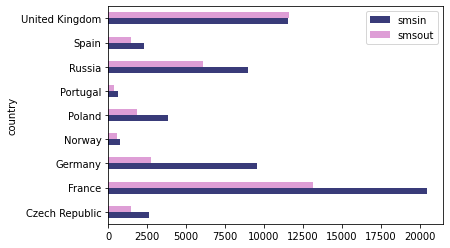

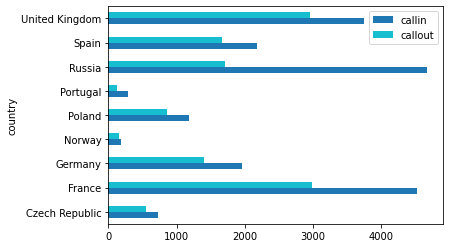

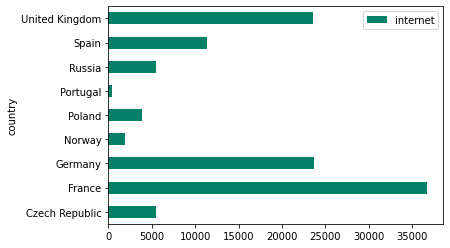

In [89]:
plotdf.plot(kind='barh', x='country', y=['smsin', 'smsout'], colormap='tab20b')
plotdf.plot(kind='barh', x='country', y=['callin', 'callout'], colormap='tab10')
plotdf.plot(kind='barh', x='country', y=['internet'], colormap='summer')

In [91]:
spark.stop()